In [1]:
import numpy as np
import powerlaw as pl
import scipy as sp
import heapq as hq
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pylab as pylab
import pickle
import os
from matplotlib.font_manager import FontProperties
import matplotlib.colors as colors
from scipy import stats

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def find_kepler(kep_list,name):
    l_list = len(kep_list)
    for i in range(l_list):
        tmp = kep_list[i][0];
        if tmp == name:
            return i

In [3]:
dir_path = os.getcwd()
dir_path = dir_path+'/star_dictionary.pickle'
def gen_hash_table(f):   
    if(os.path.exists(dir_path)):
        with open('star_dictionary.pickle', 'rb') as handle:
            return pickle.load(handle)
    else:
        f_list = f.split('\n')
        D = {}
        l_list = len(f_list);
        #list starts at element 200, the rest of the code is just parsing through the list
        for i in range(200,l_list-2):
            tmp_list = f_list[i].split()
            if tmp_list[1] == 'null':
                tmp = tmp_list[2:]
                if ((tmp[0] != 'null') & (tmp[9] != 'null') & (tmp[12] != 'null')):
                    D[tmp_list[0]] = tmp
            elif tmp_list[1] == '2MASS':
                tmp = tmp_list[3:]
                if ((tmp[0] != 'null') & (tmp[9] != 'null') & (tmp[12] != 'null')):
                    D[tmp_list[0]] = tmp
            elif (tmp_list[3] == 'B') | (tmp_list[3] == 'A'):
                tmp = tmp_list[4:]
                if ((tmp[0] != 'null') & (tmp[9] != 'null') & (tmp[12] != 'null')):
                    D[tmp_list[0]] = tmp
        with open('star_dictionary.pickle', 'wb') as handle:
            pickle.dump(D, handle, protocol=pickle.HIGHEST_PROTOCOL)
        return D

In [4]:
import scipy.io as sio
def gen_nodes(f,D):
    f_list = f.split('\n')
    f_list = f_list[:-2]
    PCA_mat = np.zeros([len(f_list),1000])
    idx = 0
    starlist = []
    for items in f_list:
        dirname = '../processed_data/'+items
        if(int(items[1]) == 0):
            starname = items[2:-4]
        else:
            starname = items[1:-4]
        mat_contents = sio.loadmat(dirname)
        a = mat_contents['a']
        d = mat_contents['d']
        #should not include any nulls
        tmp = D[starname]
        mass = float(tmp[9]); radius = float(tmp[12]); lu = 0; 
        teff = float(tmp[0]); kmag = 0; prot = 0;
        s = starnode(starname, mass, radius, lu, teff, kmag, prot, idx)
        s.save_avalance_distribution(a,d)
        s.extract_dec_of_decay()
        PCA_mat[idx,:] = s.get_av_dist()
        starlist.append(s)
        idx += 1
    return [starlist,PCA_mat]

In [5]:
#CopyLeft 2005 Juan Cardelino
#References:
#(1) Anderson, T.W., "On the distribution of the two Sample Cramer-von Mises Criterion",
#The Annals of Mathematical Statistics, Vol. 33, No. 3, Sep. 1962, pp. 1148-1159.
#(2) Andersion, T.W.; Darling, D.A "Asymptotic Theory of Certain 'Goodness of Fit' Criteria 
#Bases on Stochastic Processes"
#Last Modified: 2017.11.25 Mohammed Sheikh
#Modified: 2009.05.23 Juan Cardelino
z=np.array([
    0.00000, 0.02480, 0.02878, 0.03177, 0.03430, 0.03656, 0.03865, 0.04061, 0.04247, 
    0.04427, 0.04601, 0.04772, 0.04939, 0.05103, 0.05265, 0.05426, 0.05586, 0.05746, 
    0.05904, 0.06063, 0.06222, 0.06381, 0.06541, 0.06702, 0.06863, 0.07025, 0.07189, 
    0.07354, 0.07521, 0.07690, 0.07860, 0.08032, 0.08206, 0.08383, 0.08562, 0.08744, 
    0.08928, 0.09115, 0.09306, 0.09499, 0.09696, 0.09896, 0.10100, 0.10308, 0.10520, 
    0.10736, 0.10956, 0.11182, 0.11412, 0.11647, 0.11888, 0.12134, 0.12387, 0.12646, 
    0.12911, 0.13183, 0.13463, 0.13751, 0.14046, 0.14350, 0.14663, 0.14986, 0.15319, 
    0.15663, 0.16018, 0.16385, 0.16765, 0.17159, 0.17568, 0.17992, 0.18433, 0.18892, 
    0.19371, 0.19870, 0.20392, 0.20939, 0.21512, 0.22114, 0.22748, 0.23417, 0.24124, 
    0.24874, 0.25670, 0.26520, 0.27429, 0.28406, 0.29460, 0.30603, 0.31849, 0.33217, 
    0.34730, 0.36421, 0.38331, 0.40520, 0.43077, 0.46136, 0.49929, 0.54885, 0.61981, 
    0.74346, 1.16786])
Pz=np.concatenate((np.linspace(0,0.99,100), np.array([0.999])))

def CMtest(a1,a2,alpha):
    a = np.concatenate((a1,a2))
    N1 = len(a1); N2 = len(a2); N = N1+N2
    inds = np.argsort(a,kind='mergesort')
    
    sampleCDF1 = np.cumsum(inds<N1)
    sampleCDF2 = np.cumsum(inds>(N1-1))
    
    CMstatistic  =  N1*N2/float(np.power(N,2))*np.sum(np.power(sampleCDF1 - sampleCDF2,2))
    T_mean =1/6.0+1/(6.0 * N)
    T_var  =1/45.0*(N+1)/np.power(N,2) * ( 4.0*N1*N2*N-3.0*(np.power(N1,2)+np.power(N2,2))-
                                          2.0*N1*N2 ) / (4.0*N1*N2)
    # translate the T statistic into the limiting distribution
    CM_limiting_stat =  ( CMstatistic - T_mean ) / np.sqrt(45.0*T_var) + 1/6.0

    # interpolate
    if CM_limiting_stat > z[-1]:
        pValue=1
    elif CM_limiting_stat < z[0]:
        pValue=0
    else:
        pValue = np.interp(z,Pz,CM_limiting_stat)
    # test the hypothesis
    return np.array([alpha > 1-pValue,pValue,CMstatistic])

In [6]:
def plot_embedding(X, starlist, sel=None, title=None):
    plt.figure()
    x_min = np.amin(X[:, 0]); x_max = np.amax(X[:, 0])
    y_min = np.amin(X[:, 1]); y_max = np.amax(X[:, 1])
    mind = ((x_max-x_min)**2 + (y_max-y_min)**2) / 30;
    ax = plt.subplot(111)
                 #color=plt.cm.Set1(y[i] / 10.))
    if sel is None:
        for i in range(X.shape[0]):
            plt.scatter(X[i, 0], X[i, 1],c='b',alpha=0.3,edgecolors=None)
        if hasattr(offsetbox, 'AnnotationBbox'):
            # only print thumbnails with matplotlib > 1.0
            shown_images = np.array([[1., 1.]])  # just something big
            for i in range(X.shape[0]):
                dist = np.sum((X[i,:] - shown_images) ** 2, 1)
                if np.min(dist) < mind:
                    # don't show points that are too close
                    continue
                shown_images = np.r_[shown_images, [X[i]]]
                text = [starlist[i].mass,starlist[i].radius,starlist[i].teff]
                imagebox = offsetbox.AnnotationBbox(
                    offsetbox.TextArea(text,textprops=dict(size="small")),
                    X[i],frameon=False)
                ax.add_artist(imagebox)
        if title is not None:
            plt.title(title)
        return
    elif sel=='Temperature':
        var = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            var[i] = starlist[i].teff
    elif sel=='Radius':
        var = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            var[i] = starlist[i].radius
    elif sel=='Mass':
        var = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            var[i] = starlist[i].mass
    else:
        raise ValueError('Either select Temperature, Radius, or Mass')
    v_min = np.amin(var); v_max = np.amax(var)
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1],c=var[i],
                    s=35, vmin=v_min, vmax=v_max,alpha=0.5,edgecolors=None)
    plt.colorbar().set_label(label=sel,size=20)

In [7]:
class starnode:
    def __init__(self, name, mass, radius, lu, teff, kmag, prot, idx):
        #stellar parameters
        self.name = name
        self.mass = mass
        self.radius = radius
        self.lu = lu
        self.teff = teff
        self.kmag = kmag
        self.prot = prot
        #graph parameters
        self.neighbors = []
        self.idx = idx
        
    def save_avalance_distribution(self,avsize,avdur):
        #must take in avsize and avdur as numpy arrays
        self.avsize = np.sort(avsize[0][:])
        self.avdur = np.sort(avdur[0][:])
        self.avsize = self.avsize[-500:]
        self.avdur = self.avdur[-500:]
    
    def extract_dec_of_decay(self):
        cutoff = np.array([0.33,0.5,0.6,0.7,0.8,0.9])
        avsize_sz = self.avsize.size;
        avdur_sz  = self.avdur.size;
        maxel_size = np.amax(self.avsize)
        maxel_dur = np.amax(self.avdur)
        self.dds = np.zeros(cutoff.size)
        self.ddd = np.zeros(cutoff.size)
        for i in range(cutoff.size):
            minel_ind = int(np.floor(cutoff[i] * avsize_sz))
            minel_size = self.avsize[minel_ind]
            self.dds[i] = np.log10(maxel_size/minel_size)
            minel_ind = int(np.floor(cutoff[i] * avdur_sz))
            minel_dur = self.avdur[minel_ind]
            self.ddd[i] = np.log10(maxel_dur/minel_dur)
        
    def cmdist(self,a2,alpha):
        a1 = self.avsize
        return CMtest(a1,a2,alpha)
    
    def ksdist(self,a2):
        return stats.ks_2samp(self.avsize,a2)
    
    def extract_pl_fit(self):
        return pl.fit(self.avsize), pl.fit(self.avdur)
    
    def get_av_dist(self):
        return np.concatenate([preprocessing.scale(self.avsize),
                               preprocessing.scale(self.avdur)])
    
    def get_CCDF(self):
        size_x = self.avsize
        size_y = 1-np.linspace(0,1,size_x.shape[0])
        dur_x = self.avdur
        dur_y = 1-np.linspace(0,1,dur_x.shape[0])
        return [size_x,size_y,dur_x,dur_y]
    
    def add_neighbor(self,data):
        #neighbors are a list of tuples
        self.neighbors.append(data)
        
    def return_params(self):
        #add more parameters possibly later
        r = [np.array([self.mass, self.radius, self.lu, 
                      self.teff, self.kmag, self.prot]),self.dds,self.ddd]
        return r

In [8]:
class stargraph:
    def __init__(self,starnodes):
        #starnodes is a list of object type starnode
        self.nodes = starnodes
        #number of nearest neighbors
        
    def compute_distance(self,Compute_CM):
        #We need to generate the edges of the graph.
        #To do this, we will loop through verticies and find
        #when one vertex is connected to another vertex. Each
        #vertex stores the list of its neighbors. This will
        #then be used to construct the adjacency matrix of
        #weights.
        N = len(self.nodes)
        #store as a very long vector
        self.D = np.zeros(N*(N-1)/2)
        #Weights for the different parameters:
        #              Mass   Radius    Lu     Teff    kmag   pROT  DDS   DDD
        W = np.array([1.0e-4, 1.0e-4, 1.0e-4, 1.0e-4, 1.0e-4, 10.0])
        W2 = np.array([10.0, 10.0])
        for i in range(N):
            node = self.nodes[i]
            tmp = node.return_params()
            for j in range(i+1,N):
                ind = j - (i+1) + (N-1)*i-i*(i-1)/2
                neighbor = self.nodes[j]
                if Compute_CM: dist = node.cmdist(neighbor.avsize,0.05); self.D[ind] = dist[2]
                else: dist = node.ksdist(neighbor.avsize); self.D[ind] = dist[0]
                tmp1 = neighbor.return_params()
                
    #populate first NN neighbors  
    def gen_edges(self, NN):
        N = len(self.nodes)
        for i in range(N):
            node = self.nodes[i]
            #reinitialize the list
            node.neighbors = []
            nneighbor_list = []
            for j in range(N):
                if i!=j:
                    neighbor = self.nodes[j]
                    #either i < j or i > j, so if i < j, use regular indices
                    #if i > j, swap the role of i and j
                    if (i < j):
                        ind = j - (i+1) + (N-1)*i-i*(i-1)/2
                    else:
                        ind = i - (j+1) + (N-1)*j-j*(j-1)/2
                    if len(nneighbor_list) < NN:
                        #push the greatest element onto the heap
                        hq.heappush(nneighbor_list,(-self.D[ind],neighbor))
                    else:
                        #if the element is smaller than the largest heap element, 
                        #push it onto the heap
                        tmp = hq.heappop(nneighbor_list)
                        if (self.D[ind] < -tmp[0]):
                            hq.heappush(nneighbor_list,(-self.D[ind],neighbor))
                        else:
                            hq.heappush(nneighbor_list,tmp)
            for nns in nneighbor_list:
                node.add_neighbor(nns)

    #We split up the adjacency matrix and the generation of the graph for simplicity.
    #For the graph we are looking at here, we will need to use a sparse matrix representation
    #The sparse representation is in COO (coordinate) format
    def gen_adj_matrix(self):
        N = len(self.nodes)
        data = []
        ridx = []; cidx = [];
        for node in self.nodes:
            for neighbor in node.neighbors:
                #data.append(-neighbor[0])
                data.append(1)
                ridx.append(node.idx)
                cidx.append(neighbor[1].idx)
        adj = sp.sparse.coo_matrix((data, (ridx,cidx)), (N, N))
        #need a symmetric matrix, note that if adj encodes j as the NN of i, then j will not
        #necessarily choose i as one of its' nearest neighbors. Therefore the entry 
        #adj_{ij} > 0 but adj_{ji} = 0. The simplest rememdy is to set adj_{ji} = adj_{ij}.
        #Note that if i and j are both neighbors of each other, this method doesn't change
        #anything as the distance from i to j is the same as from j to i.
        adj = np.ceil(0.5 * (adj + adj.T))
        return adj

In [9]:
fprops = open("../nph-nstedAPI.txt").read()
D = gen_hash_table(fprops)

In [10]:
fmat = open('../processed_data/matfiles.txt').read()
ll = gen_nodes(fmat,D)
starlist = ll[0]
PCA_mat = ll[1]

In [11]:
U, s, V = np.linalg.svd(PCA_mat, full_matrices=False)
d = 2
s_t = np.zeros(d); s_t = s[:d]
S = np.diag(s_t)
X_PCA = np.dot(U[:,:d],S);

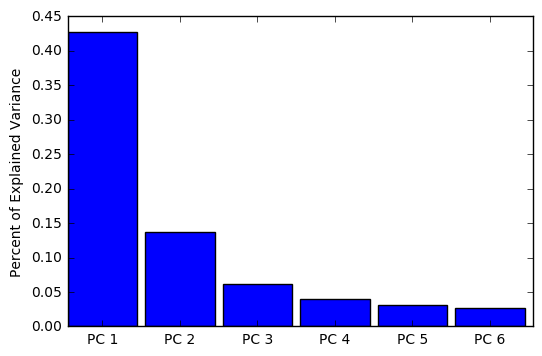

In [12]:
N = 6
var_exp = s[:N]/sum(s)
ind = np.arange(N)
width = 0.9
fig, ax = plt.subplots()
rects1 = ax.bar(ind, var_exp, width)
ax.set_ylabel('Percent of Explained Variance')
x=['PC %s' %i for i in range(1,N+1)]
ax.set_xticks((ind + width / 2))
ax.set_xticklabels(x)
plt.show()

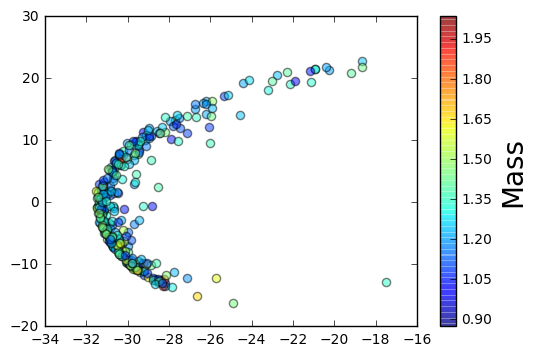

In [13]:
mode = 'Mass'
plot_embedding(X_PCA,starlist,sel=mode)
pylab.savefig('figures/python_figs/PCA_parameters_'+mode+'.png')
plt.show()

In [14]:
sg = stargraph(starlist)
sg.compute_distance(1)

In [15]:
sg.gen_edges(20)
adj = sg.gen_adj_matrix()
import sklearn.manifold
se = sklearn.manifold.SpectralEmbedding(n_components=2,affinity='precomputed')
Xn = se.fit_transform(adj.toarray())

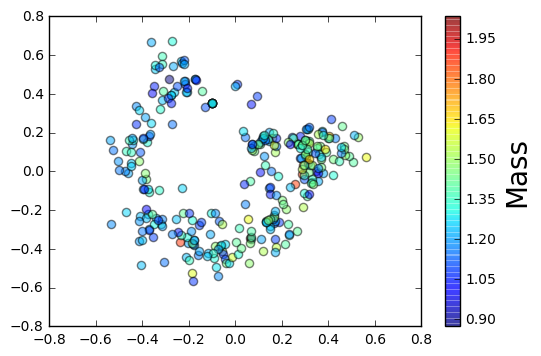

In [16]:
mode = 'Mass'
plot_embedding(Xn,starlist,sel=mode)
pylab.savefig('figures/python_figs/LE_parameters_CM_NN20_'+mode+'.png')
plt.show()